<a href="https://colab.research.google.com/github/g4m3r0/AvaloniaDemoCalculator/blob/main/ReservoirComputing_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 5.1 MB/s eta 0:00:00


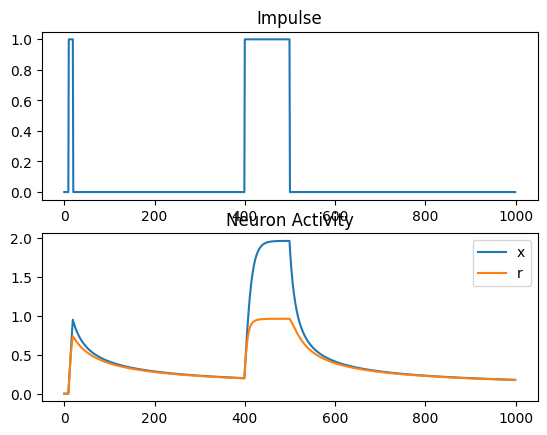

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import control

class RecurrentNetworkForce(object):
    def __init__(self, config):
        # Copy the parameters
        self.Ni = config['Ni']
        self.N = config['N']
        self.N_u = config['N'] # N and N_u should always have the same neuron size
        self.No = config['No']
        self.No_u = config['No_u']
        self.tau = config['tau']
        self.tau_u = config['tau_u']
        self.g = config['g']
        self.g_u = config['g_u']
        self.pc = config['pc']
        self.pc_u = config['pc_u']
        self.Io = config['Io']
        self.P_plastic = config['P_plastic']
        self.P_plastic_u = config['P_plastic_u']
        self.N_plastic = int(self.P_plastic*self.N)
        self.N_plastic_u = int(self.P_plastic_u*self.N_u)

        # Input
        self.I = np.zeros((self.Ni, 1))

        # Recurrent population
        self.x = np.random.uniform(-1.0, 1.0, (self.N, 1))
        self.x_u = np.random.uniform(-1.0, 1.0, (self.N_u, 1))
        self.r_x = np.tanh(self.x)
        self.r_u = np.tanh(self.x_u)

        # Read-out population
        self.y = np.zeros((self.No, 1))
        self.u = np.zeros((self.No_u, 1))

        # Weights between the input and recurrent units
        self.W_in = np.random.randn(self.N, self.Ni)

        # Weights between the recurrent units
        self.W_rec = (np.random.randn(self.N, self.N) * self.g/np.sqrt(self.pc*self.N))
        self.W_rec_u = (np.random.randn(self.N_u, self.N_u) * self.g_u/np.sqrt(self.pc_u*self.N_u))

        # The connection pattern is sparse with p=0.1
        connectivity_mask = np.random.binomial(1, self.pc, (self.N, self.N))
        connectivity_mask[np.diag_indices(self.N)] = 0
        self.W_rec *= connectivity_mask

        connectivity_mask_u = np.random.binomial(1, self.pc_u, (self.N_u, self.N_u))
        connectivity_mask_u[np.diag_indices(self.N_u)] = 0
        self.W_rec_u *= connectivity_mask_u

        # Store the pre-synaptic neurons to each plastic neuron
        self.W_plastic = [list(np.nonzero(connectivity_mask[i, :])[0]) for i in range(self.N_plastic)]
        self.W_plastic_u = [list(np.nonzero(connectivity_mask_u[i, :])[0]) for i in range(self.N_plastic_u)]

        # Output weights
        self.W_out = (np.random.randn(self.No, self.N) / np.sqrt(self.N))
        self.W_out_u = (np.random.randn(self.No_u, self.N_u) / np.sqrt(self.N_u))

        # Setting up LQR matrices
        self.Q = np.identity(self.N)
        self.Q_u = np.identity(self.N_u)
        self.R = np.identity(self.Ni)
        self.R_u = np.identity(self.N_u)
        #self.R_u = np.identity(self.Ni)

        # Inverse correlation matrix of inputs for learning readout weights
        self.P_out = [np.identity(self.N) for i in range(self.No)]
        self.P_out_u = [np.identity(self.N_u) for i in range(self.No_u)]

    def step(self, I, noise, feedback):
        # Noise can be shut off
        I_noise = (self.Io * np.random.randn(self.N, 1) if noise else 0.0)

        # tau * dx/dt + x = I + W_rec * r + I_noise
        if feedback:
            self.x += (np.dot(self.W_in, I) + np.dot(self.W_rec, self.r_x) + I_noise - self.x)/self.tau
        else:
            self.x += (np.dot(self.W_in, I) + np.dot(self.W_rec, self.r_x) + self.r_u + I_noise - self.x)/self.tau
            self.x_u += (np.dot(self.W_rec_u, self.r_u) + self.r_x - self.x_u) / self.tau_u

        # r = tanh(x)
        self.r_x = np.tanh(self.x)
        self.r_u = np.tanh(self.x_u)

        # z = W_out * r
        self.y = np.dot(self.W_out, self.r_x)
        self.u = np.dot(self.W_out_u, self.r_u)

    def train_recurrent(self, target):
        """
        Applies the RLS learning rule to the recurrent weights.

        * `target`: desired trajectory at time t, numpy array of shape (N, 1)
        """
        # Compute the error of the recurrent neurons
        error_x = self.r_x - target

        # Apply the FORCE learning rule to the recurrent weights
        for i in range(self.N_plastic): # for each plastic post neuron

            # Get the rates from the plastic synapses only
            r_plastic = self.r_x[self.W_plastic[i]]

            # Multiply the inverse correlation matrix P*R with the rates from the plastic synapses only
            PxR = np.dot(self.P[i], self.r_x[self.W_plastic[i]])

            # Normalization term 1 + R'*P*R
            RxPxR = (1. + np.dot(r_plastic.T,  PxR))

            # Update the inverse correlation matrix P <- P - ((P*R)*(P*R)')/(1+R'*P*R)
            self.P[i] -= np.dot(PxR, PxR.T)/RxPxR

            # Learning rule W <- W - e * (P*R)/(1+R'*P*R)
            self.W_rec[i, self.W_plastic[i]] -= error_x[i, 0] * (PxR/RxPxR)[:, 0]
        return np.abs(error_x).sum() / self.N_plastic

    def train_recurrent_thalamus(self, target):
        """
        Applies the RLS learning rule to the recurrent weights.

        * `target`: desired trajectory at time t, numpy array of shape (N, 1)
        """
        # Compute the error of the recurrent neurons
        error_u = self.r_u - target

        # Apply the FORCE learning rule to the recurrent weights
        for i in range(self.N_plastic_u): # for each plastic post neuron

            # Get the rates from the plastic synapses only
            r_plastic = self.r_u[self.W_plastic_u[i]]

            # Multiply the inverse correlation matrix P*R with the rates from the plastic synapses only
            PxR = np.dot(self.P_u[i], self.r_u[self.W_plastic_u[i]])

            # Normalization term 1 + R'*P*R
            RxPxR = (1. + np.dot(r_plastic.T,  PxR))

            # Update the inverse correlation matrix P <- P - ((P*R)*(P*R)')/(1+R'*P*R)
            self.P_u[i] -= np.dot(PxR, PxR.T)/RxPxR

            # Learning rule W <- W - e * (P*R)/(1+R'*P*R)
            self.W_rec_u[i, self.W_plastic_u[i]] -= error_u[i, 0] * (PxR/RxPxR)[:, 0]
        return np.abs(error_u).sum() / self.N_plastic_u

    def train_readout(self, target):
        """
        Applies the RLS learning rule to the readout weights.

        * `target`: desired output at time t, numpy array of shape (No, 1)
        """

        # Compute the error of the output neurons
        error_y = self.y - target

        # Apply the FORCE learning rule to the readout weights
        for i in range(self.No): # for each readout neuron

            # Multiply the rates with the inverse correlation matrix P*R
            PxR = np.dot(self.P_out[i], self.r_x)

            # Normalization term 1 + R'*P*R
            RxPxR = (1. + np.dot(self.r_x.T,  PxR))

            # Update the inverse correlation matrix P <- P - ((P*R)*(P*R)')/(1+R'*P*R)
            self.P_out[i] -= np.dot(PxR, PxR.T)/RxPxR

            # Learning rule W <- W - e * (P*R)/(1+R'*P*R)
            self.W_out[i, :] -= error_y[i, 0] * (PxR/RxPxR)[:, 0]

        return np.abs(error_y).sum() / self.No

    def save(self, filename:str):
        with open(filename, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
            print('Net saved as {0}'.format(filename))

    def load(self, filename:str):
        with open(filename, 'rb') as f:
            self = pickle.load(f)
            print('Net ' + filename + ' loaded.')

def load(filename):
    with open(filename, 'rb') as f:
        net : RecurrentNetworkLQR = pickle.load(f)
    print('Net {0}  loaded.'.format(filename))
    return net

class Neuron():
    def __init__(self, tau, noise = 0.):
        self.x = 0.
        self.r = 0.
        self.noise = noise
        self.tau = tau

    def step(self, I):
        dx = (I + self.r + self.noise - self.x) / self.tau
        self.x += dx
        self.r = np.tanh(self.x)
        return self.x, self.r

if __name__ == '__main__':
    # Test code for showing the neuron activity on a impulse
    neuron = Neuron(tau=10)

    I = np.zeros(1000)
    I[10:20] = 1.
    I[400:500] = 1.

    X = []
    R = []

    for t in range(I.shape[0]):
        x, r = neuron.step(I[t])
        X.append(x)
        R.append(r)

    plt.subplot(2, 1, 1)
    plt.title('Impulse')
    plt.plot(I)

    plt.subplot(2, 1, 2)
    plt.title('Neuron Activity')
    plt.plot(X, label='x')
    plt.plot(R, label='r')
    plt.legend()
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import control

class RecurrentNetworkLQR(object):
    def __init__(self, config):
        # Copy the parameters
        self.Ni = config['Ni']
        self.N = config['N']
        self.N_u = config['N'] # N and N_u should always have the same neuron size
        self.No = config['No']
        self.No_u = config['No_u']
        self.tau = config['tau']
        self.tau_u = config['tau_u']
        self.g = config['g']
        self.g_u = config['g_u']
        self.pc = config['pc']
        self.pc_u = config['pc_u']
        self.Io = config['Io']
        self.P_plastic = config['P_plastic']
        self.P_plastic_u = config['P_plastic_u']
        self.N_plastic = int(self.P_plastic*self.N)
        self.N_plastic_u = int(self.P_plastic_u*self.N_u)

        # Input
        self.I = np.zeros((self.Ni, 1))

        # Recurrent population
        self.x = np.random.uniform(-1.0, 1.0, (self.N, 1))
        self.x_u = np.random.uniform(-1.0, 1.0, (self.N_u, 1))
        self.r_x = np.tanh(self.x)
        self.r_u = np.tanh(self.x_u)

        # Read-out population
        self.y = np.zeros((self.No, 1))
        self.u = np.zeros((self.No_u, 1))

        # Weights between the input and recurrent units
        self.W_in = np.random.randn(self.N, self.Ni)

        # Weights between the recurrent units
        self.W_rec = (np.random.randn(self.N, self.N) * self.g/np.sqrt(self.pc*self.N))
        self.W_rec_u = (np.random.randn(self.N_u, self.N_u) * self.g_u/np.sqrt(self.pc_u*self.N_u))

        # The connection pattern is sparse with p=0.1
        connectivity_mask = np.random.binomial(1, self.pc, (self.N, self.N))
        connectivity_mask[np.diag_indices(self.N)] = 0
        self.W_rec *= connectivity_mask

        connectivity_mask_u = np.random.binomial(1, self.pc_u, (self.N_u, self.N_u))
        connectivity_mask_u[np.diag_indices(self.N_u)] = 0
        self.W_rec_u *= connectivity_mask_u

        # Store the pre-synaptic neurons to each plastic neuron
        self.W_plastic = [list(np.nonzero(connectivity_mask[i, :])[0]) for i in range(self.N_plastic)]
        self.W_plastic_u = [list(np.nonzero(connectivity_mask_u[i, :])[0]) for i in range(self.N_plastic_u)]

        # Output weights
        self.W_out = (np.random.randn(self.No, self.N) / np.sqrt(self.N))
        self.W_out_u = (np.random.randn(self.No_u, self.N_u) / np.sqrt(self.N_u))

        # Setting up LQR matrices
        self.Q = np.identity(self.N)
        self.Q_u = np.identity(self.N_u)
        self.R = np.identity(self.Ni)
        self.R_u = np.identity(self.N_u)
        #self.R_u = np.identity(self.Ni)

        # Inverse correlation matrix of inputs for learning readout weights
        self.P_out = [np.identity(self.N) for i in range(self.No)]
        self.P_out_u = [np.identity(self.N_u) for i in range(self.No_u)]

    def step(self, I, noise, feedback):
        # Noise can be shut off
        I_noise = (self.Io * np.random.randn(self.N, 1) if noise else 0.0)

        # tau * dx/dt + x = I + W_rec * r + I_noise
        if feedback:
            self.x += (np.dot(self.W_in, I) + np.dot(self.W_rec, self.r_x) + I_noise - self.x)/self.tau
        else:
            self.x += (np.dot(self.W_in, I) + np.dot(self.W_rec, self.r_x) + self.r_u + I_noise - self.x)/self.tau
            self.x_u += (np.dot(self.W_rec_u, self.r_u) + self.r_x - self.x_u) / self.tau_u

        # r = tanh(x)
        self.r_x = np.tanh(self.x)
        self.r_u = np.tanh(self.x_u)

        # z = W_out * r
        self.y = np.dot(self.W_out, self.r_x)
        self.u = np.dot(self.W_out_u, self.r_u)

    def train_recurrent(self, target):
        """
        Train the recurrent weights using LQR.

        The LQR problem is defined as:
        Minimize:
            J = ∫ (x^T Q x + u^T R u) dt
        Subject to the dynamics:
            dx/dt = Ax + Bu

        Where:
        x(t) is the state of the system at time t.
        u(t) is the control input at time t.
        Q is a positive semi-definite matrix (state error weight).
        R is a positive definite matrix (control effort weight).

        The optimal control law is given by:
        u(t) = -Kx(t)
        Where K is the state feedback gain.
        """

        K, _, _ = control.lqr(self.W_rec, self.W_in, self.Q, self.R)
        self.W_rec -= K
        error_x = self.r_x - target
        return np.abs(error_x).sum() / self.N_plastic

    def train_recurrent_thalamus(self, target):
        """
        Train the recurrent weights of the thalamus using LQR.
        The problem formulation is the same as described in the train_recurrent method.
        """

        K_u, _, _ = control.lqr(self.W_rec_u, self.W_in, self.Q_u, self.R_u)
        self.W_rec_u -= K_u
        error_u = self.r_u - target
        return np.abs(error_u).sum() / self.N_plastic_u

    def train_readout(self, target):
        """
        Applies the RLS learning rule to the readout weights.

        * `target`: desired output at time t, numpy array of shape (No, 1)
        """

        # Compute the error of the output neurons
        error_y = self.y - target

        # Apply the FORCE learning rule to the readout weights
        for i in range(self.No): # for each readout neuron

            # Multiply the rates with the inverse correlation matrix P*R
            PxR = np.dot(self.P_out[i], self.r_x)

            # Normalization term 1 + R'*P*R
            RxPxR = (1. + np.dot(self.r_x.T,  PxR))

            # Update the inverse correlation matrix P <- P - ((P*R)*(P*R)')/(1+R'*P*R)
            self.P_out[i] -= np.dot(PxR, PxR.T)/RxPxR

            # Learning rule W <- W - e * (P*R)/(1+R'*P*R)
            self.W_out[i, :] -= error_y[i, 0] * (PxR/RxPxR)[:, 0]

        return np.abs(error_y).sum() / self.No

    def save(self, filename:str):
        with open(filename, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
            print('Net saved as {0}'.format(filename))

    def load(self, filename:str):
        with open(filename, 'rb') as f:
            self = pickle.load(f)
            print('Net ' + filename + ' loaded.')

def load(filename):
    with open(filename, 'rb') as f:
        net : RecurrentNetworkLQR = pickle.load(f)
    print('Net {0}  loaded.'.format(filename))
    return net

class Neuron():
    def __init__(self, tau, noise = 0.):
        self.x = 0.
        self.r = 0.
        self.noise = noise
        self.tau = tau

    def step(self, I):
        dx = (I + self.r + self.noise - self.x) / self.tau
        self.x += dx
        self.r = np.tanh(self.x)
        return self.x, self.r

# 3D Lorenz Attractor

In [ ]:
from scipy.integrate import solve_ivp

if __name__ == '__main__':
    # Define network parameters
    config = {
        'Ni': 3,             # Number of input neurons
        'N': 100,             # Number of recurrent neurons in the primary reservoir
        'N_u': 100,           # Number of recurrent neurons in the secondary (thalamus) reservoir
        'No': 3,             # Number of read-out neurons from the primary reservoir
        'No_u': 1,           # Number of read-out neurons from the secondary (thalamus) reservoir
        'tau': 10,           # Time constant of neurons in the primary reservoir
        'tau_u': 10,         # Time constant of neurons in the secondary (thalamus) reservoir
        'g': 1.5,            # Synaptic strength scaling for the primary reservoir
        'g_u': 1.5,          # Synaptic strength scaling for the secondary (thalamus) reservoir
        'pc': 0.1,           # Connection probability between neurons in the primary reservoir
        'pc_u': 0.1,         # Connection probability between neurons in the secondary (thalamus) reservoir
        'Io': 0.1,          # Noise variance added to the neurons in the primary reservoir
        'P_plastic': 0.2,    # Percentage of neurons in the primary reservoir receiving plastic synapses
        'P_plastic_u': 0.2   # Percentage of neurons in the secondary (thalamus) reservoir receiving plastic synapses
    }

    net = RecurrentNetworkLQR(config)

    # Step 1: Generate the Lorenz Attractor Data
    def lorenz(t, z, sigma=10, rho=28, beta=2.667):
        x, y, z = z
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return [dx, dy, dz]

    z0 = [1, 1, 1]
    t_span = [0, 25]
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    lorenz_data = solve_ivp(lorenz, t_span, z0, t_eval=t_eval).y.T

    # Step 2: Split Data into Training and Testing Sets
    #train_size = int(0.8 * len(lorenz_data))
    #test_size = len(lorenz_data) - train_size

    #train_data = lorenz_data[:train_size]
    #test_data = lorenz_data[train_size:]

    # As we dont want to test the network on unseen data our test and train set is the same
    train_size = test_size = len(lorenz_data)
    train_data = test_data = lorenz_data


    # Step 3: Train the Network
    training_predictions = []
    first_epoch_predictions = []
    last_epoch_predictions = []
    epoch_losses = []

    num_epochs = 10  # For example, train for 5 epochs

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_predictions = []

        for t in range(train_size - 1):
            current_input = train_data[t].reshape(3, 1)  # Reshape to (3, 1) for 3D input
            target = train_data[t + 1].reshape(3, 1)  # Reshape to (3, 1) for 3D input
            net.step(current_input, noise=False, feedback=False)
            net.train_readout(target)
            prediction = net.y.flatten()  # Assuming net.y is now a 3D vector
            epoch_predictions.append(prediction)
            epoch_loss += np.sum((prediction - target.flatten()) ** 2)

        epoch_loss /= (train_size - 1)
        epoch_losses.append(epoch_loss)

        if epoch == 0:
            first_epoch_predictions = epoch_predictions.copy()
        elif epoch == num_epochs - 1:
            last_epoch_predictions = epoch_predictions.copy()

    # Step 4: Test the Network for One-Step-Ahead Prediction
    one_step_predictions = []

    for t in range(test_size - 1):
        current_input = train_data[t].reshape(3, 1)
        target = train_data[t + 1].reshape(3, 1)
        net.step(current_input, noise=False, feedback=False)
        prediction = net.y.flatten()
        one_step_predictions.append(prediction)

    one_step_predictions = np.array(one_step_predictions)
    testing_loss = np.mean(np.sum((test_data[1:] - one_step_predictions) ** 2, axis=1))

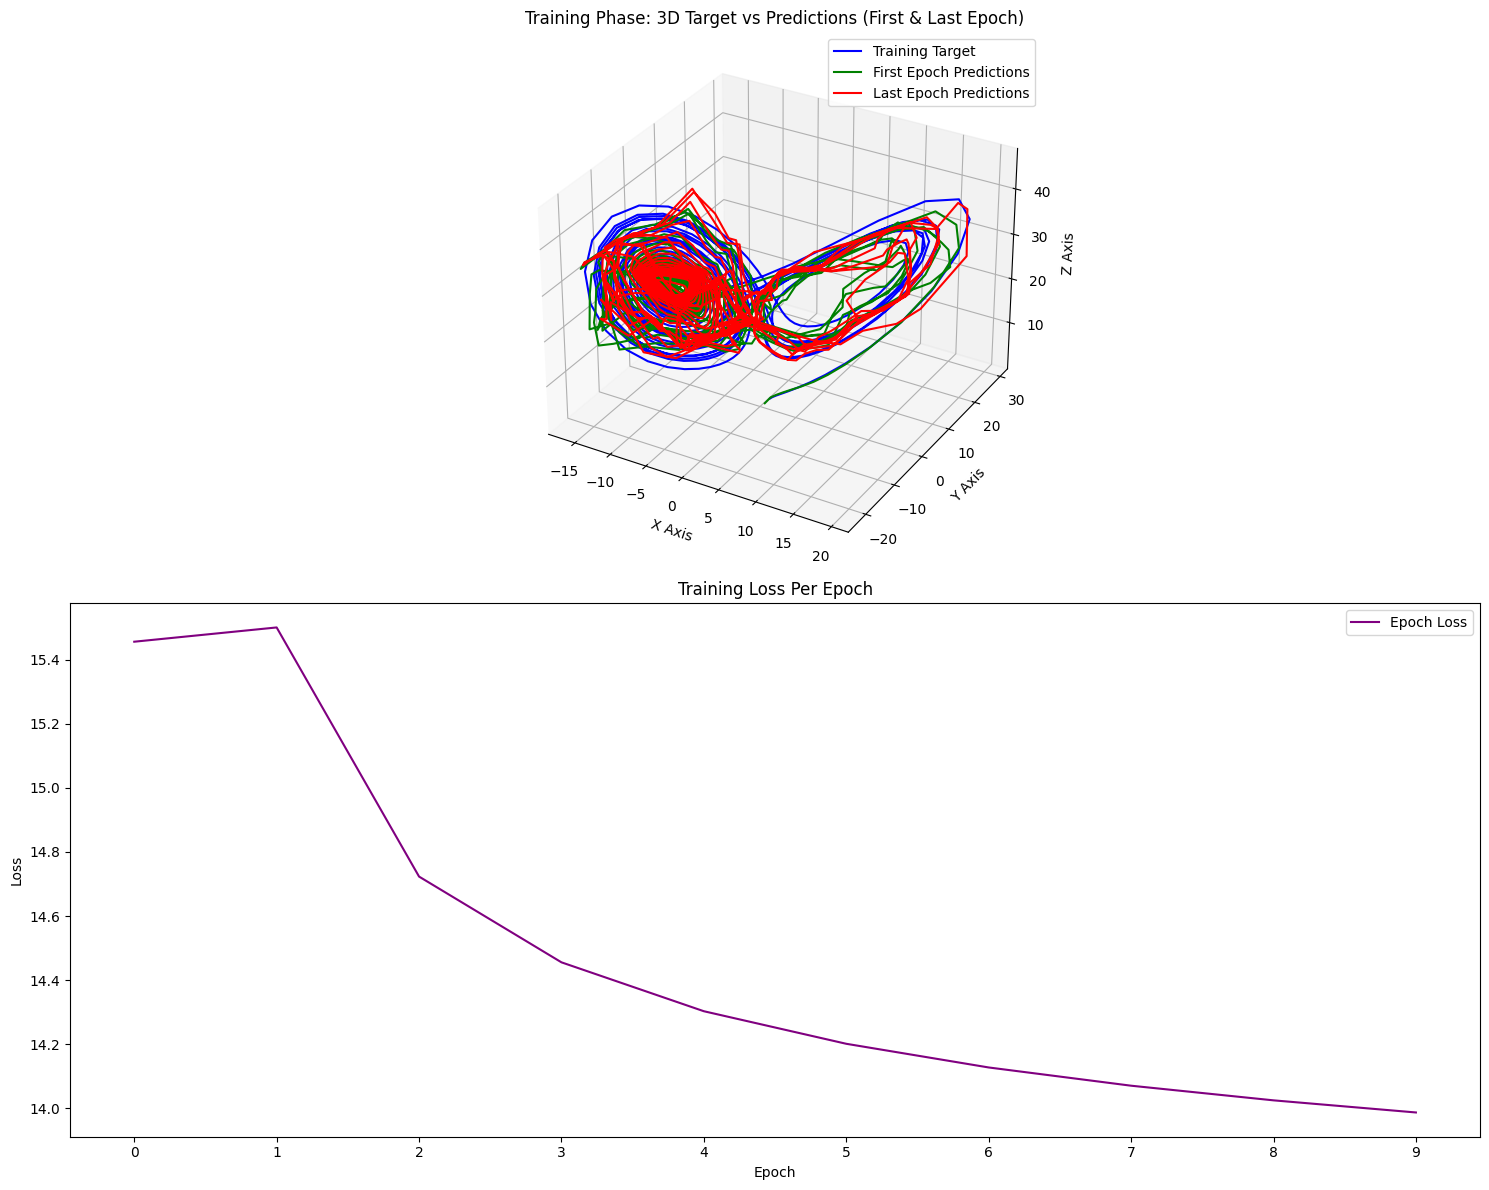

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(15, 12))

# 3D Plot for Training Phase - First and Last Epoch
ax1 = plt.subplot(2, 1, 1, projection='3d')
ax1.plot(train_data[:, 0], train_data[:, 1], train_data[:, 2], label='Training Target', color='blue')
ax1.plot(np.array(first_epoch_predictions)[:, 0], np.array(first_epoch_predictions)[:, 1], np.array(first_epoch_predictions)[:, 2], label='First Epoch Predictions', color='green')
ax1.plot(np.array(last_epoch_predictions)[:, 0], np.array(last_epoch_predictions)[:, 1], np.array(last_epoch_predictions)[:, 2], label='Last Epoch Predictions', color='red')
ax1.set_title('Training Phase: 3D Target vs Predictions (First & Last Epoch)')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Z Axis')
ax1.legend()

# Plot for Loss/Error Over Epochs
ax2 = plt.subplot(2, 1, 2)
ax2.plot(epoch_losses, label='Epoch Loss', color='purple')
ax2.set_title('Training Loss Per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
epoch_indices = range(0, num_epochs, max(1, num_epochs // 10))
ax2.set_xticks(epoch_indices, labels=[str(i) for i in epoch_indices])
ax2.legend()

plt.tight_layout()
plt.show()

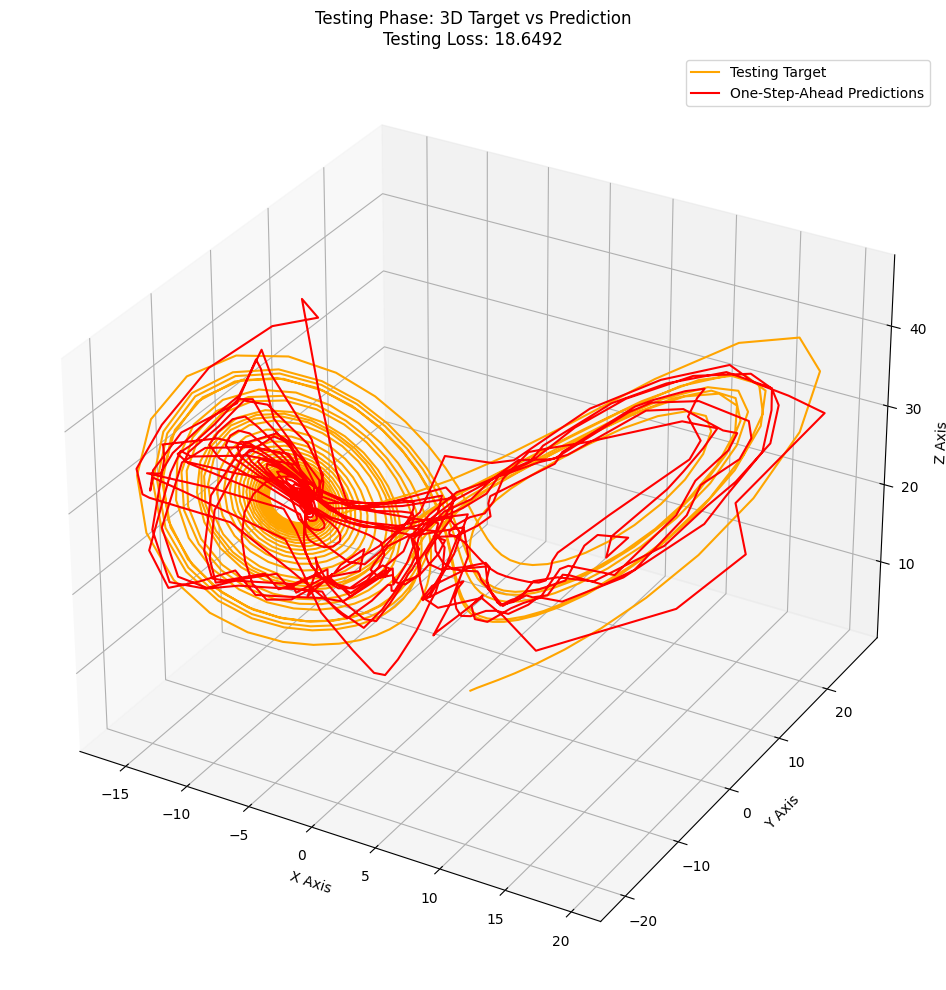

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(15, 10))

# 3D Plot for Testing Phase
ax = plt.subplot(111, projection='3d')
ax.plot(test_data[1:, 0], test_data[1:, 1], test_data[1:, 2], label='Testing Target', color='orange')
ax.plot(one_step_predictions[:, 0], one_step_predictions[:, 1], one_step_predictions[:, 2], label='One-Step-Ahead Predictions', color='red')
ax.set_title(f'Testing Phase: 3D Target vs Prediction\nTesting Loss: {testing_loss:.4f}')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.legend()

plt.tight_layout()
plt.show()


# 3D Lorenz Experiment (Classes)

In [5]:
class ReservoirExperiment:
    def __init__(self, network, train_data, test_data, noise = False, feedback = False):
        self.network = network
        self.train_data = train_data
        self.test_data = test_data
        self.feedback = feedback
        self.noise = noise

        self.training_predictions = []
        self.epoch_losses = []
        self.one_step_predictions = []
        self.last_epoch_predictions = []

    def train(self, num_epochs=50):
        for epoch in range(num_epochs):
            epoch_loss = 0
            epoch_predictions = []

            for t in range(len(self.train_data) - 1):
                current_input = self.train_data[t].reshape(3, 1)
                target = self.train_data[t + 1].reshape(3, 1)
                self.network.step(current_input, noise=self.noise, feedback=self.feedback)
                self.network.train_readout(target)

                prediction = self.network.y.flatten()
                epoch_predictions.append(prediction)
                epoch_loss += np.sum((prediction - target.flatten()) ** 2) # Mean Squared Error (MSE)

            epoch_loss /= (len(self.train_data) - 1) # Average Mean Squared Error (MSE)
            self.epoch_losses.append(epoch_loss)

            if epoch == 0:
                self.first_epoch_predictions = epoch_predictions.copy()
            elif epoch == num_epochs - 1:
                self.last_epoch_predictions = epoch_predictions.copy()

            self.training_predictions.append(epoch_predictions)

    def test(self):
        test_loss = 0
        for t in range(len(self.test_data) - 1):
            current_input = self.test_data[t].reshape(3, 1)
            self.network.step(current_input, noise=self.noise, feedback=self.feedback)
            prediction = self.network.y.flatten()
            self.one_step_predictions.append(prediction)
            target = self.test_data[t + 1]
            test_loss += np.sum((prediction - target) ** 2)

        self.testing_loss = test_loss / (len(self.test_data) - 1)
        self.one_step_predictions = np.array(self.one_step_predictions)

    def visualize_training(self):
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        plt.figure(figsize=(15, 6))
        ax1 = plt.subplot(1, 1, 1, projection='3d')

        # Plot the target data
        ax1.plot(self.train_data[:, 0], self.train_data[:, 1], self.train_data[:, 2],
                 label='Training Target', color='blue')

        # Plot the first epoch predictions
        ax1.plot(np.array(self.first_epoch_predictions)[:, 0],
                 np.array(self.first_epoch_predictions)[:, 1],
                 np.array(self.first_epoch_predictions)[:, 2],
                 label='First Epoch Predictions', color='green')

        # Plot the last epoch predictions
        ax1.plot(np.array(self.last_epoch_predictions)[:, 0],
                 np.array(self.last_epoch_predictions)[:, 1],
                 np.array(self.last_epoch_predictions)[:, 2],
                 label='Last Epoch Predictions', color='red')

        ax1.set_title('Training Phase: 3D Target vs Predictions (First & Last Epoch)')
        ax1.set_xlabel('X Axis')
        ax1.set_ylabel('Y Axis')
        ax1.set_zlabel('Z Axis')
        ax1.legend()
        plt.show()

    def visualize_epoch_losses(self):
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_losses, label='Epoch Loss', color='purple')
        plt.title('Training Average MSE Loss Per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        epoch_indices = range(0, len(self.epoch_losses), max(1, len(self.epoch_losses) // 10))
        plt.xticks(epoch_indices, labels=[str(i) for i in epoch_indices])
        plt.legend()
        plt.tight_layout()
        plt.show()

    def visualize_testing(self):
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt

        plt.figure(figsize=(15, 6))
        ax = plt.subplot(1, 1, 1, projection='3d')
        ax.plot(self.test_data[1:, 0], self.test_data[1:, 1], self.test_data[1:, 2],
                label='Testing Target', color='orange')
        ax.plot(self.one_step_predictions[:, 0], self.one_step_predictions[:, 1],
                self.one_step_predictions[:, 2], label='One-Step-Ahead Predictions', color='red')
        ax.set_title(f'Testing Phase: 3D Target vs Prediction\nTesting Loss: {self.testing_loss:.4f}')
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        ax.legend()
        plt.show()


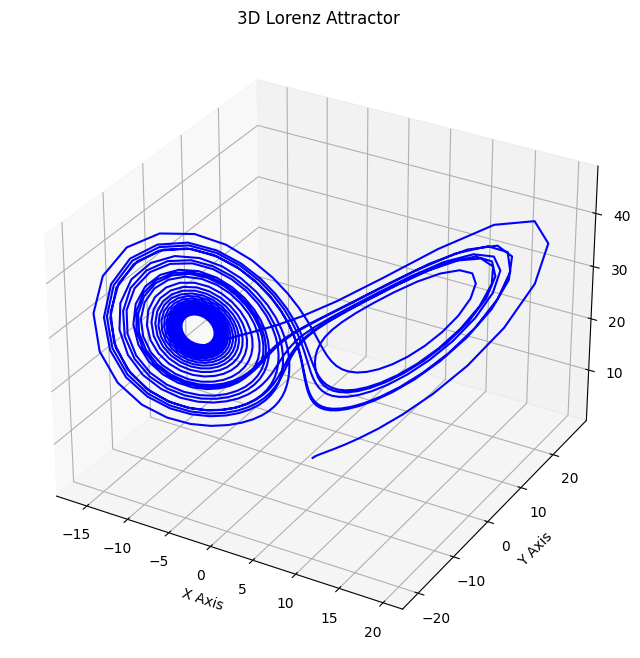

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class LorenzAttractorDataGenerator:
    def __init__(self, sigma=10, rho=28, beta=2.667, initial_state=[1, 1, 1], t_span=[0, 25], points=1000):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.initial_state = initial_state
        self.t_span = t_span
        self.points = points

    def lorenz(self, t, z):
        x, y, z = z
        dx = self.sigma * (y - x)
        dy = x * (self.rho - z) - y
        dz = x * y - self.beta * z
        return [dx, dy, dz]

    def generate_data(self):
        t_eval = np.linspace(self.t_span[0], self.t_span[1], self.points)
        solution = solve_ivp(self.lorenz, self.t_span, self.initial_state, t_eval=t_eval)
        return solution.y.T

    def print_data(self, data):
        plt.figure(figsize=(10, 8))
        ax = plt.axes(projection='3d')
        ax.plot(data[:, 0], data[:, 1], data[:, 2], color='blue')
        ax.set_title('3D Lorenz Attractor')
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        plt.show()

if __name__ == '__main__':
  # Test code for showing the default lorez attractor
  data_generator = LorenzAttractorDataGenerator()
  lorenz_data = data_generator.generate_data()
  data_generator.print_data(lorenz_data)

## Experiment (No Feedback)

In [ ]:
data_generator = LorenzAttractorDataGenerator()
lorenz_data = data_generator.generate_data()

Experiment with RecurrentNetworkLQR


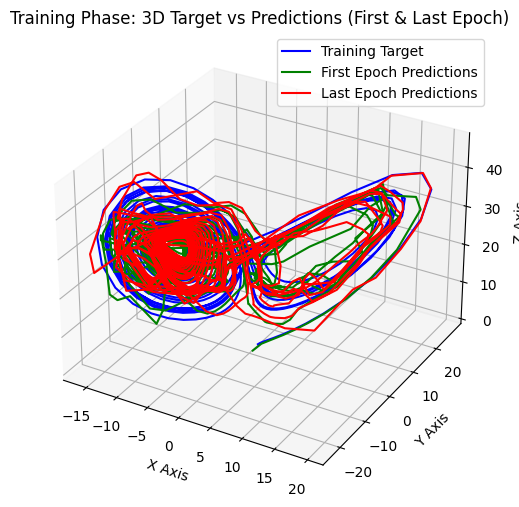

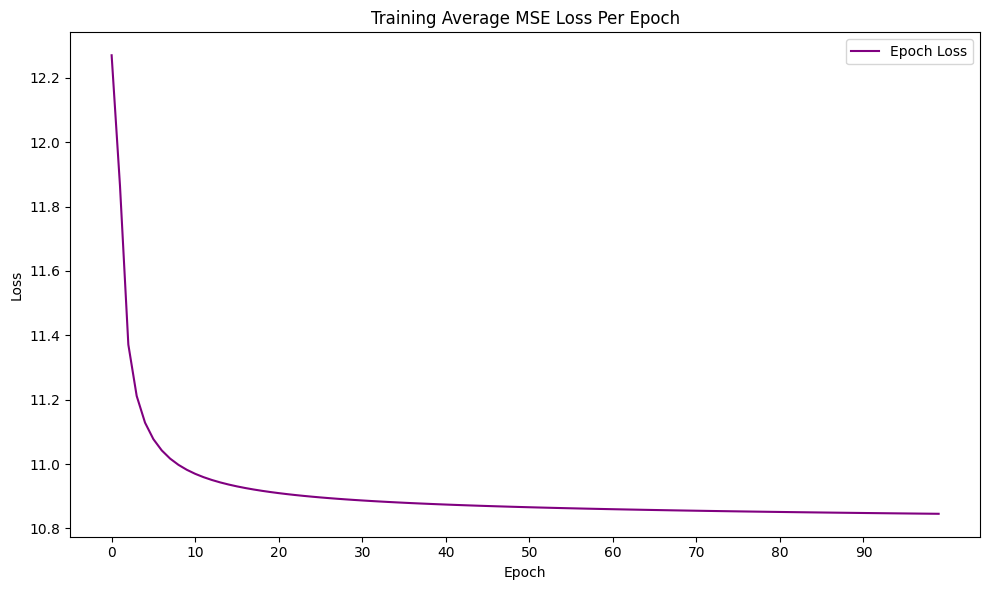

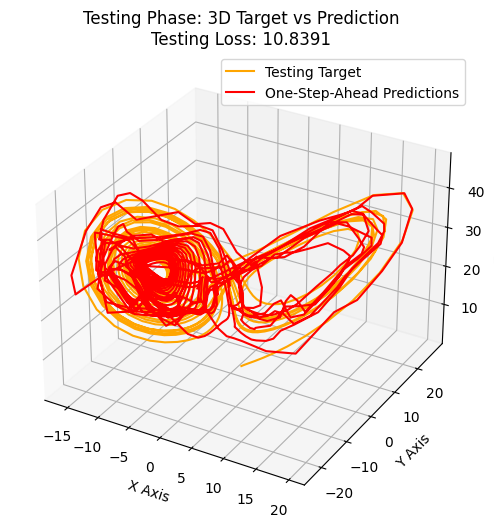

Experiment with RecurrentNetworkForce


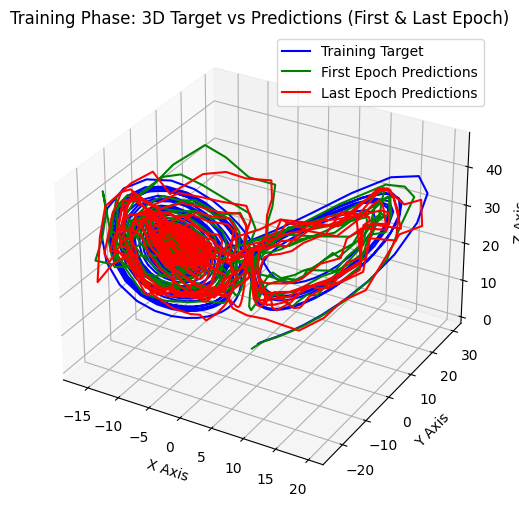

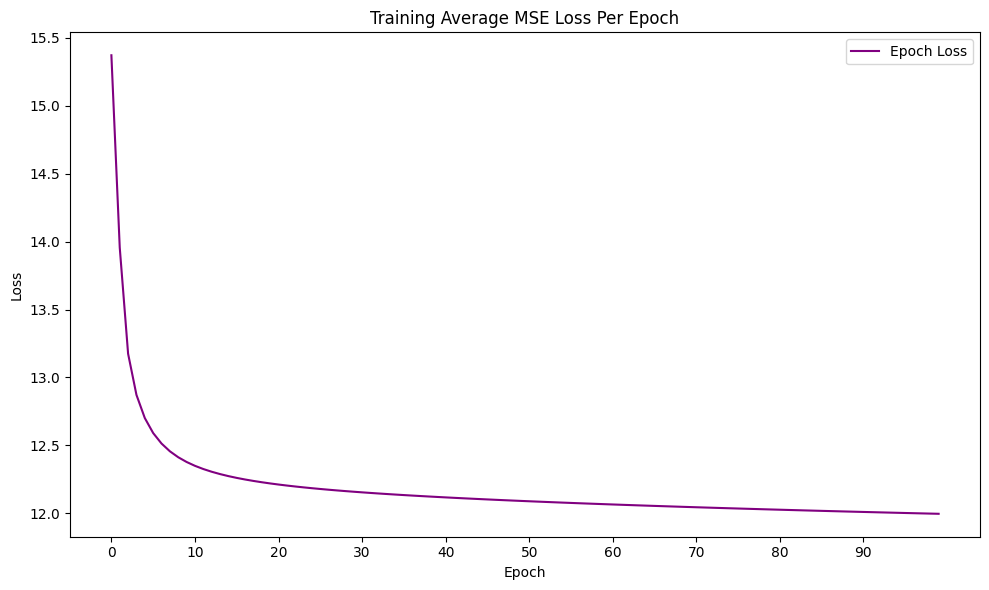

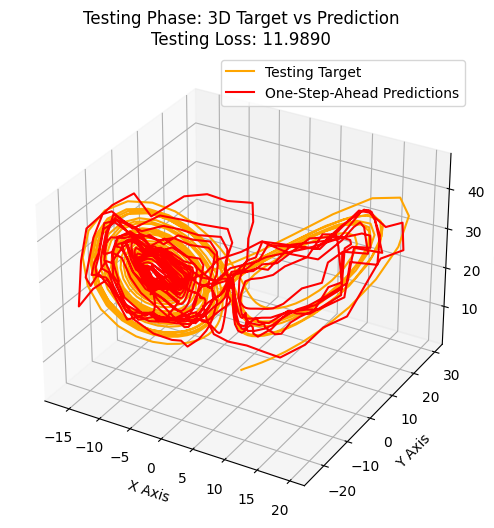

In [ ]:
base_config = {
    'Ni': 3, 'N': 100, 'N_u': 100, 'No': 3, 'No_u': 1,
    'tau': 10, 'tau_u': 10, 'g': 1.5, 'g_u': 1.5, 'pc': 0.1,
    'pc_u': 0.1, 'Io': 0.1, 'P_plastic': 0.2, 'P_plastic_u': 0.2
}

noise = False
feedback = False

train_data = test_data = lorenz_data

num_epochs = 100

# Experiment with RecurrentNetworkLQR
print("Experiment with RecurrentNetworkLQR")
network_lqr = RecurrentNetworkLQR(base_config)
experiment_lqr = ReservoirExperiment(network_lqr, train_data, test_data, noise=noise, feedback=feedback)
experiment_lqr.train(num_epochs=num_epochs)
experiment_lqr.visualize_training()
experiment_lqr.visualize_epoch_losses()
experiment_lqr.test()
experiment_lqr.visualize_testing()

# Experiment with RecurrentNetworkForce
print("Experiment with RecurrentNetworkForce")
network_force = RecurrentNetworkForce(base_config)
experiment_force = ReservoirExperiment(network_force, train_data, test_data, noise=noise, feedback=feedback)
experiment_force.train(num_epochs=num_epochs)
experiment_force.visualize_training()
experiment_force.visualize_epoch_losses()
experiment_force.test()
experiment_force.visualize_testing()

## Experiment (With Feedback)

Experiment with RecurrentNetworkLQR


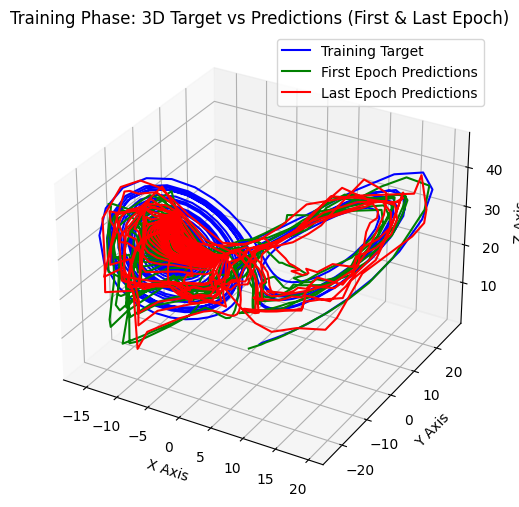

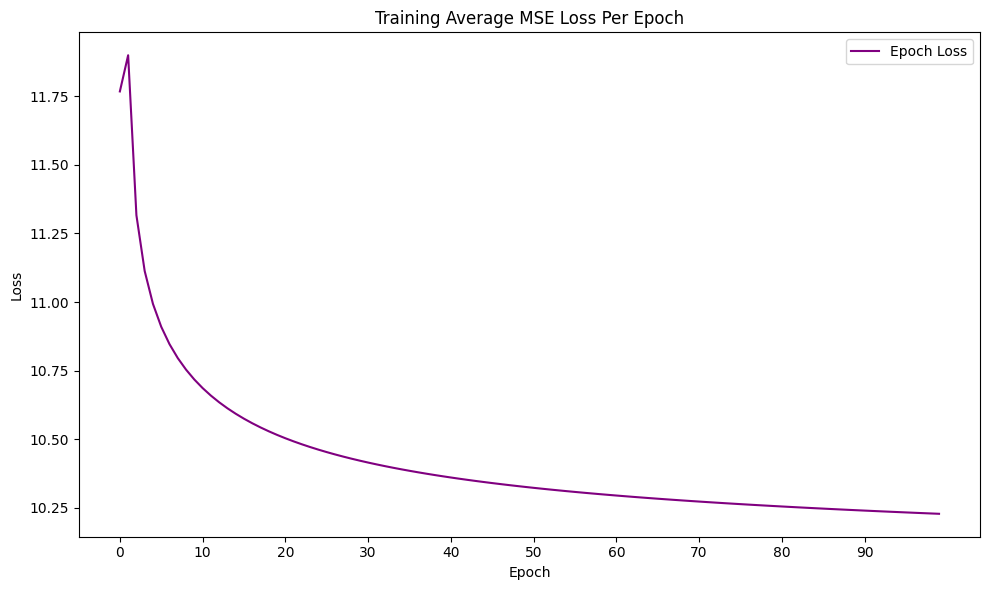

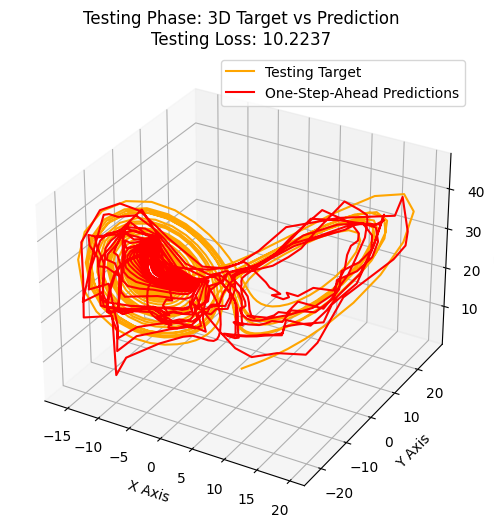

Experiment with RecurrentNetworkForce


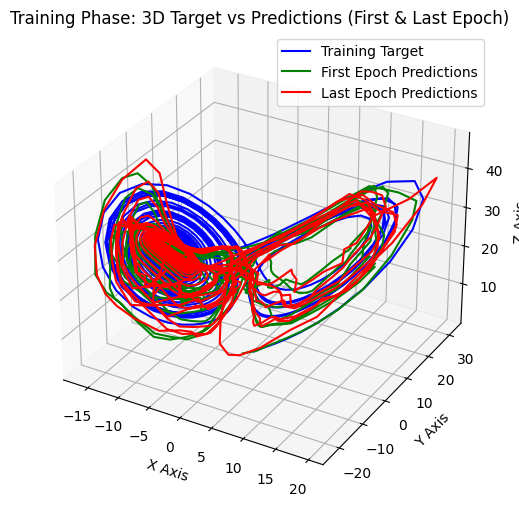

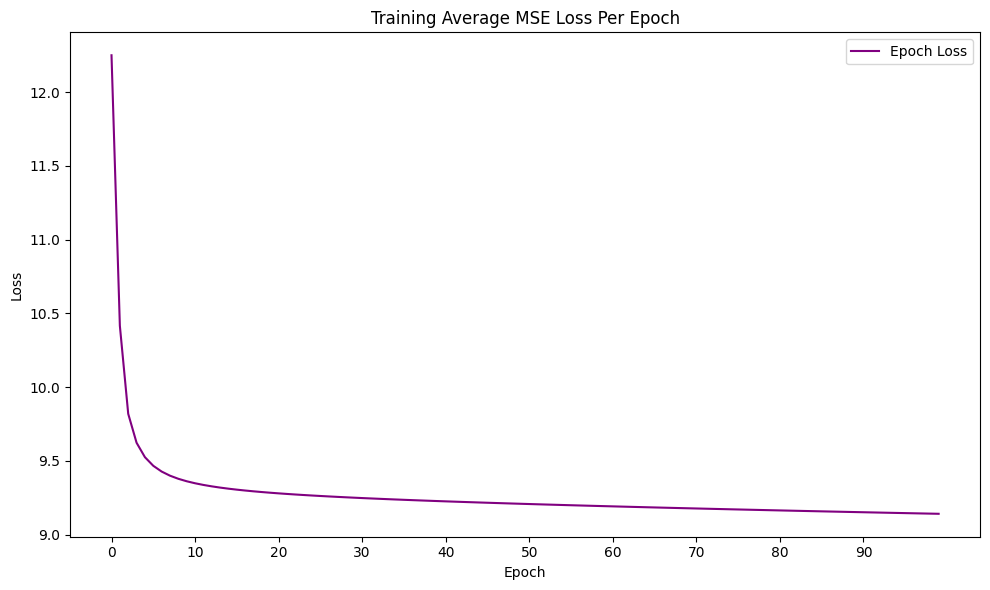

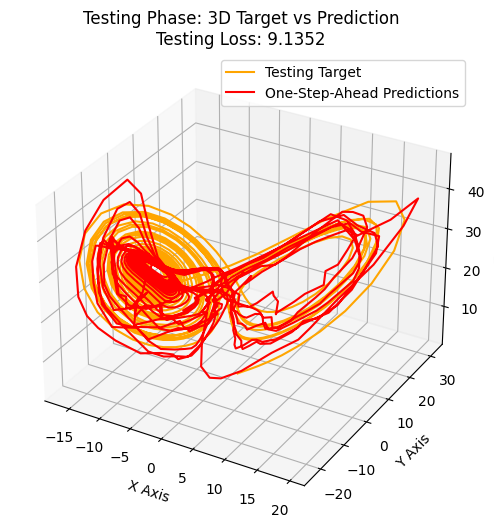

In [ ]:
base_config = {
    'Ni': 3, 'N': 100, 'N_u': 100, 'No': 3, 'No_u': 1,
    'tau': 10, 'tau_u': 10, 'g': 1.5, 'g_u': 1.5, 'pc': 0.1,
    'pc_u': 0.1, 'Io': 0.1, 'P_plastic': 0.2, 'P_plastic_u': 0.2
}

noise = False
feedback = True

train_data = test_data = lorenz_data

num_epochs = 100

# Experiment with RecurrentNetworkLQR
print("Experiment with RecurrentNetworkLQR")
network_lqr = RecurrentNetworkLQR(base_config)
experiment_lqr = ReservoirExperiment(network_lqr, train_data, test_data, noise=noise, feedback=feedback)
experiment_lqr.train(num_epochs=num_epochs)
experiment_lqr.visualize_training()
experiment_lqr.visualize_epoch_losses()
experiment_lqr.test()
experiment_lqr.visualize_testing()

# Experiment with RecurrentNetworkForce
print("Experiment with RecurrentNetworkForce")
network_force = RecurrentNetworkForce(base_config)
experiment_force = ReservoirExperiment(network_force, train_data, test_data, noise=noise, feedback=feedback)
experiment_force.train(num_epochs=num_epochs)
experiment_force.visualize_training()
experiment_force.visualize_epoch_losses()
experiment_force.test()
experiment_force.visualize_testing()

## Parameter Tuning

In [7]:
class ParameterTuner:
    def __init__(self, base_config, train_data, test_data, noise, feedback):
        self.base_config = base_config
        self.train_data = train_data
        self.test_data = test_data

        self.noise = noise
        self.feedback = feedback

    def tune_parameters(self, parameter_ranges, num_epochs=5):
        best_config = None
        best_loss = float('inf')
        best_network = None

        for config in self.generate_configs(parameter_ranges):
            network = RecurrentNetworkLQR(config)
            experiment = ReservoirExperiment(network, self.train_data, self.test_data, noise=self.noise, feedback=self.feedback)

            experiment.train(num_epochs=num_epochs)
            experiment.visualize_training()
            experiment.visualize_epoch_losses()

            experiment.test()
            experiment.visualize_testing()

            # Print the results of the current configuration
            print(f"\nConfig: {config}\nTesting Loss: {experiment.testing_loss}\n")

            if experiment.testing_loss < best_loss:
                best_loss = experiment.testing_loss
                best_config = config
                best_network = network

        # Print the best results before returning
        print("\nBest Configuration:\n")
        print(f"Config: {best_config}\n")
        print(f"Testing Loss: {best_loss}\n")

        return best_config, best_loss, best_network

    def generate_configs(self, parameter_ranges):
        from itertools import product

        keys, values = zip(*parameter_ranges.items())
        for v in product(*values):
            config = self.base_config.copy()
            config.update(dict(zip(keys, v)))
            yield config


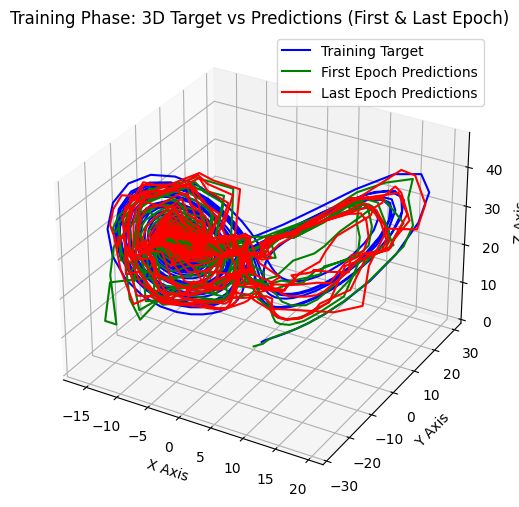

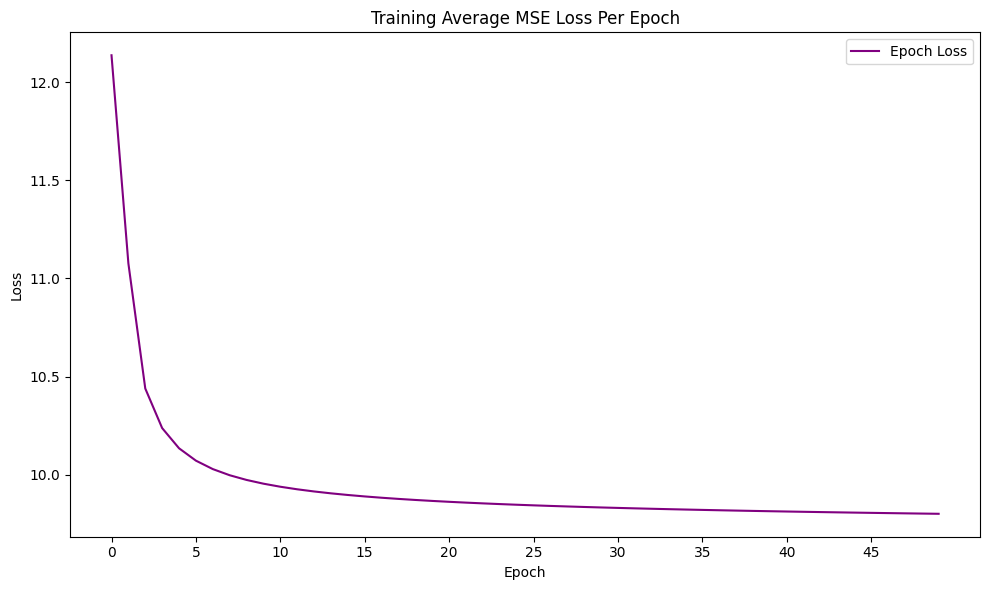

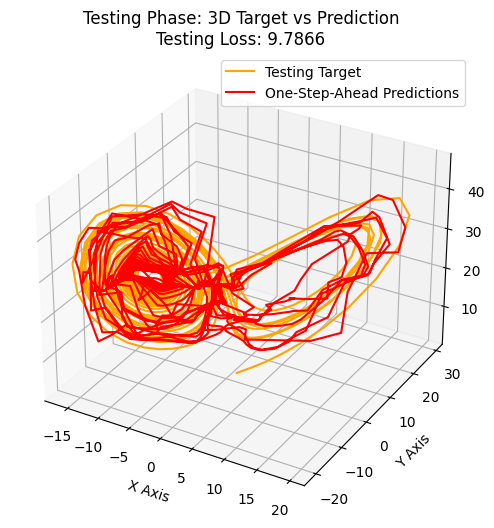


Config: {'Ni': 3, 'N': 100, 'N_u': 100, 'No': 3, 'No_u': 1, 'tau': 10, 'tau_u': 10, 'g': 1.5, 'g_u': 1.5, 'pc': 0.1, 'pc_u': 0.1, 'Io': 0.1, 'P_plastic': 0.2, 'P_plastic_u': 0.2}
Testing Loss: 9.786579884588942



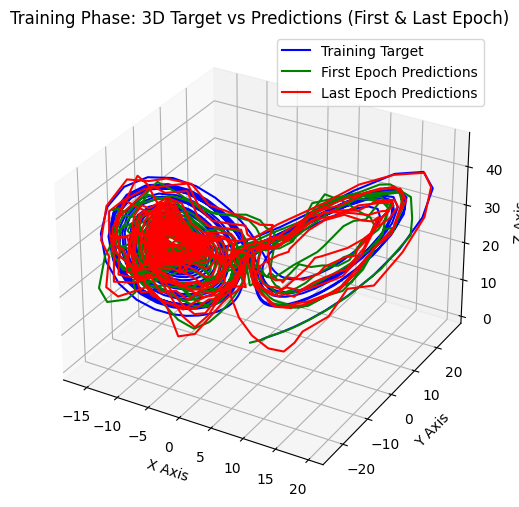

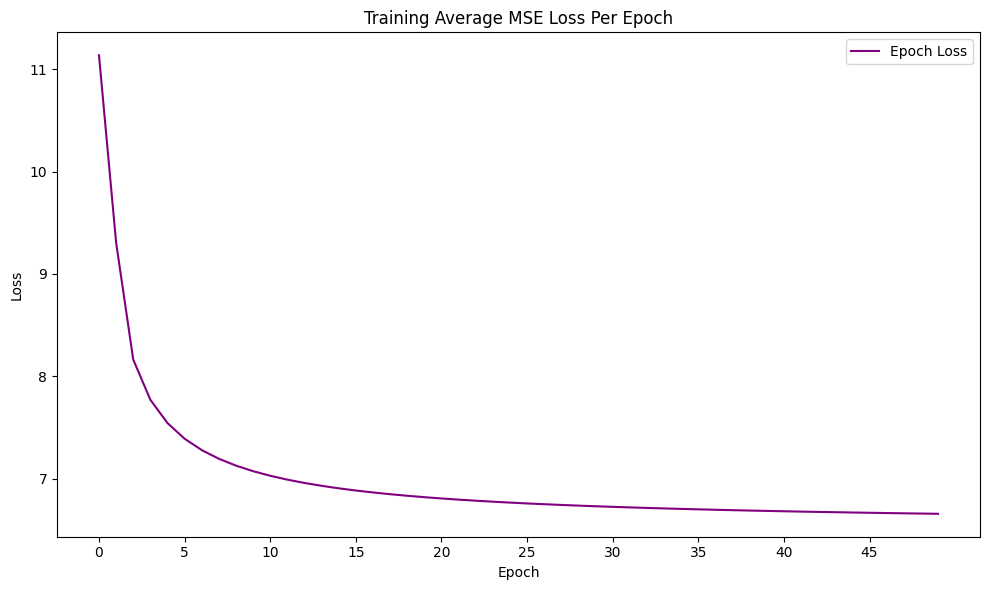

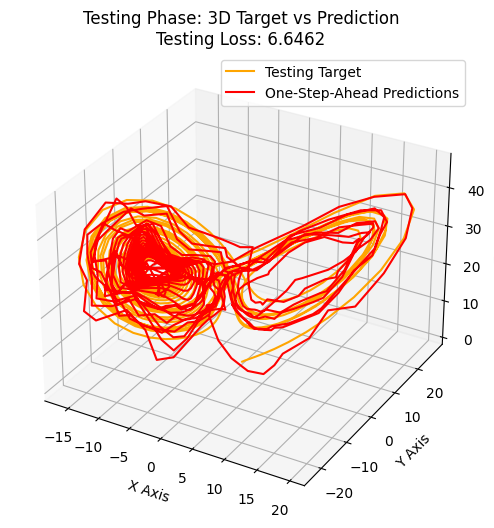


Config: {'Ni': 3, 'N': 200, 'N_u': 100, 'No': 3, 'No_u': 1, 'tau': 10, 'tau_u': 10, 'g': 1.5, 'g_u': 1.5, 'pc': 0.1, 'pc_u': 0.1, 'Io': 0.1, 'P_plastic': 0.2, 'P_plastic_u': 0.2}
Testing Loss: 6.6462457728912865



In [ ]:
base_config = {
    'Ni': 3, 'N': 100, 'N_u': 100, 'No': 3, 'No_u': 1,
    'tau': 10, 'tau_u': 10, 'g': 1.5, 'g_u': 1.5, 'pc': 0.1,
    'pc_u': 0.1, 'Io': 0.1, 'P_plastic': 0.2, 'P_plastic_u': 0.2
}

parameter_ranges = {
    'N': [100, 200, 500, 1000],
    #'g': [1.0, 1.5, 2.0],
    # Add other parameters as needed
}

noise = False
feedback = True

data_generator = LorenzAttractorDataGenerator()
lorenz_data = data_generator.generate_data()

tuner = ParameterTuner(base_config, lorenz_data, lorenz_data, noise=noise, feedback=feedback)
best_config, best_loss, best_network = tuner.tune_parameters(parameter_ranges, num_epochs=50)

# 1D Lorenz Attractor

In [ ]:
from scipy.integrate import solve_ivp

if __name__ == '__main__':
    # Define network parameters
    config = {
        'Ni': 2,             # Number of input neurons
        'N': 60,             # Number of recurrent neurons in the primary reservoir
        'N_u': 60,           # Number of recurrent neurons in the secondary (thalamus) reservoir
        'No': 1,             # Number of read-out neurons from the primary reservoir
        'No_u': 1,           # Number of read-out neurons from the secondary (thalamus) reservoir
        'tau': 10,           # Time constant of neurons in the primary reservoir
        'tau_u': 10,         # Time constant of neurons in the secondary (thalamus) reservoir
        'g': 1.5,            # Synaptic strength scaling for the primary reservoir
        'g_u': 1.5,          # Synaptic strength scaling for the secondary (thalamus) reservoir
        'pc': 0.1,           # Connection probability between neurons in the primary reservoir
        'pc_u': 0.1,         # Connection probability between neurons in the secondary (thalamus) reservoir
        'Io': 0.1,          # Noise variance added to the neurons in the primary reservoir
        'P_plastic': 0.2,    # Percentage of neurons in the primary reservoir receiving plastic synapses
        'P_plastic_u': 0.2   # Percentage of neurons in the secondary (thalamus) reservoir receiving plastic synapses
    }

    net = RecurrentNetworkLQR(config)

    # Simulation parameters
    total_time = 2000
    train_time = 1500

    # Input and target storage
    inputs = np.zeros((total_time, config['Ni'], 1))
    targets = np.zeros((total_time, config['No'], 1))
    outputs = np.zeros((total_time, config['No'], 1))

    errors = 0

    def lorenz(t, z, sigma=10, rho=28, beta=8/3):
        x, y, z = z
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return [dx, dy, dz]

    # Initial condition
    z0 = [1, 1, 1]
    t_span = (0, 25)
    t_eval = np.linspace(*t_span, total_time)

    sol = solve_ivp(lorenz, t_span, z0, t_eval=t_eval)
    lorenz_wave = sol.y[0]  # Using x-values for demonstration


    for t in range(total_time):
        # Generate sine wave as target
        targets[t] = lorenz_wave[t] #np.sin(2 * np.pi * t / 50)

        # Random input
        inputs[t] = np.random.randn(config['Ni'], 1)

        # Step the network
        net.step(inputs[t], noise=True, disable_feedback=False)
        outputs[t] = net.y

        # Train during the training phase
        if t < train_time:
            net.train_readout(targets[t])

    # Plot results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(targets.squeeze(), label='Target (sine wave)')
    plt.plot(outputs.squeeze(), label='Network output')
    plt.axvline(train_time, color='red', linestyle='--', label='End of Training')
    plt.legend()
    plt.title('Network Training & Testing on Sine Wave Generation')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(errors, label='Mean Squared Error (MSE)')
    plt.axvline(train_time, color='red', linestyle='--', label='End of Training')
    plt.legend()
    plt.title('Error Evolution During Training')
    plt.xlabel('Time')
    plt.ylabel('MSE')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
from scipy.integrate import solve_ivp

if __name__ == '__main__':
    # Define network parameters
    config = {
        'Ni': 1,             # Number of input neurons
        'N': 120,             # Number of recurrent neurons in the primary reservoir
        'N_u': 120,           # Number of recurrent neurons in the secondary (thalamus) reservoir
        'No': 1,             # Number of read-out neurons from the primary reservoir
        'No_u': 1,           # Number of read-out neurons from the secondary (thalamus) reservoir
        'tau': 10,           # Time constant of neurons in the primary reservoir
        'tau_u': 10,         # Time constant of neurons in the secondary (thalamus) reservoir
        'g': 1.5,            # Synaptic strength scaling for the primary reservoir
        'g_u': 1.5,          # Synaptic strength scaling for the secondary (thalamus) reservoir
        'pc': 0.1,           # Connection probability between neurons in the primary reservoir
        'pc_u': 0.1,         # Connection probability between neurons in the secondary (thalamus) reservoir
        'Io': 0.1,          # Noise variance added to the neurons in the primary reservoir
        'P_plastic': 0.2,    # Percentage of neurons in the primary reservoir receiving plastic synapses
        'P_plastic_u': 0.2   # Percentage of neurons in the secondary (thalamus) reservoir receiving plastic synapses
    }

    net = RecurrentNetworkLQR(config)

    # Step 1: Generate the Lorenz Attractor Data
    def lorenz(t, z, sigma=10, rho=28, beta=2.667):#sigma=10, rho=28, beta=8/3):
        x, y, z = z
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return [dx, dy, dz]

    # Generate Lorenz attractor data
    z0 = [1, 1, 1]  # Initial conditions
    t_span = [0, 25]  # Time span
    t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points where the solution is computed
    lorenz_data = solve_ivp(lorenz, t_span, z0, t_eval=t_eval).y[0]  # Using x-component

    # Step 2: Split Data into Training and Testing Sets
    train_size = int(0.8 * len(lorenz_data))
    test_size = len(lorenz_data) - train_size

    train_data = lorenz_data[:train_size]
    test_data = lorenz_data[train_size:]

    # Step 3: Train the Network
    training_predictions = []
    first_epoch_predictions = []
    last_epoch_predictions = []
    epoch_losses = []

    num_epochs = 500  # For example, train for 5 epochs

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_predictions = []

        for t in range(train_size - 1):
            current_input = np.array([[train_data[t]]])  # Format input as needed
            target = np.array([[train_data[t + 1]]])  # Next step is the target
            net.step(current_input, noise=False, disable_feedback=False)

            net.train_readout(target)  # Train readout
            prediction = net.y.item()
            epoch_predictions.append(prediction)
            epoch_loss += (prediction - target[0, 0]) ** 2  # simple squared error

        epoch_loss /= (train_size - 1)  # Average loss for the epoch
        epoch_losses.append(epoch_loss)

        if epoch == 0:
            first_epoch_predictions = epoch_predictions.copy()
        elif epoch == num_epochs - 1:
            last_epoch_predictions = epoch_predictions.copy()

    #for epoch in range(num_epochs):
    #    for t in range(train_size - 1):
    #        current_input = np.array([[train_data[t]]])  # Format input as needed
    #        target = np.array([[train_data[t + 1]]])  # Next step is the target
    #        net.step(current_input, noise=True, disable_feedback=False)
    #        net.train_readout(target)  # Train readout
    #        training_predictions.append(net.y.item())  # Store the prediction

    # Step 4: Test the Network for One-Step-Ahead Prediction
    one_step_predictions = []

    for t in range(test_size - 1):
        current_input = np.array([[test_data[t]]])
        net.step(current_input, noise=True, disable_feedback=False)
        one_step_predictions.append(net.y.item())  # net.y is the prediction

    one_step_predictions = np.array(one_step_predictions)
    testing_loss = sum((test_data[1:] - one_step_predictions) ** 2) / len(one_step_predictions)

    # Step 5: Test the Network for Multi-Step-Ahead Prediction
    multi_step_predictions = []
    steps_ahead = 5
    current_input = np.array([[test_data[0]]])

    for t in range(steps_ahead):
        net.step(current_input, noise=True, disable_feedback=False)
        current_input = np.array([[net.y.item()]])
        multi_step_predictions.append(net.y.item())

    multi_step_predictions = np.array(multi_step_predictions)


In [ ]:
plt.figure(figsize=(15, 8))

# Plot for Training Phase - First and Last Epoch
plt.subplot(2, 1, 1)
plt.plot(train_data[1:], label='Training Target', color='blue')
plt.plot(first_epoch_predictions, label='First Epoch Predictions', color='green')
plt.plot(last_epoch_predictions, label='Last Epoch Predictions', color='red')
plt.title('Training Phase: Target vs Predictions (First & Last Epoch)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

# Plot for Loss/Error Over Epochs
plt.subplot(2, 1, 2)
plt.plot(epoch_losses, label='Epoch Loss', color='purple')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adjust x-axis to show a subset of epochs or use a different scale
epoch_indices = range(0, num_epochs, max(1, num_epochs // 10))  # Show every 10th epoch
plt.xticks(epoch_indices, labels=[str(i) for i in epoch_indices])

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 6: Visualization of Results
plt.figure(figsize=(15, 8))

# Plot for Testing Phase
plt.subplot(3, 1, 3)
plt.plot(test_data[1:], label='Testing Target', color='orange')
plt.plot(one_step_predictions, label='One-Step-Ahead Predictions', color='red')
plt.title(f'Testing Phase: Target vs Prediction\nTesting Loss: {testing_loss:.4f}')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Step 6: Visualization of Results
plt.figure(figsize=(15, 8))

# Plot for Training Phase
plt.subplot(2, 1, 1)
# Loop the target data for each epoch
for epoch in range(num_epochs):
    plt.plot(range(epoch * (train_size - 1), (epoch + 1) * (train_size - 1)), train_data[1:], label=f'Epoch {epoch+1} Target', color='blue', alpha=0.5)
plt.plot(training_predictions, label='Training Predictions', color='red')
plt.title('Training Phase: Target vs Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

# Plot for Testing Phase
plt.subplot(2, 1, 2)
plt.plot(test_data[1:], label='Testing Target', color='orange')  # Shift target by one for aligning with predictions
plt.plot(one_step_predictions, label='One-Step-Ahead Predictions', color='red')
plt.plot(range(train_size, train_size + len(multi_step_predictions)), multi_step_predictions, label='Multi-Step-Ahead Predictions', color='green')
plt.title('Testing Phase: Target vs Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()